In [ ]:
!pip install tensorflow
!pip install keras
!pip install keras_tuner

ERROR: Could not install packages due to an OSError: [WinError 5] \u62d2\u7edd\u8bbf\u95ee\u3002: 'C:\\Users\\lenovo\\anaconda3\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [ ]:
import pandas as pd
import math
from datetime import datetime
import numpy as np
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Embedding, Flatten, Input, concatenate
from keras_tuner import BayesianOptimization, RandomSearch
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import tensorflow.keras.backend as K
import sklearn
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers
import warnings
warnings.filterwarnings("ignore")

#  1. Data Preprocessing

In [ ]:
data = pd.read_csv(r'C:\Users\zhua273\Desktop\Project Data\ProjectTrainingData.csv')
# data = pd.read_csv(r'C:\Users\HSUN93\Desktop\Project Data\ProjectTrainingData.csv')

In [ ]:
# feature engineering
data = data.drop(['id'],axis=1)
data['hh'] = data['hour'].mod(100)
data['dd'] = (data['hour']-data['hh']-14100000)/100

In [ ]:
train.groupby('hh')['click'].mean().plot()

In [ ]:
train.groupby('dd')['click'].mean().plot()

In [ ]:
train.groupby('hour')['click'].mean().plot(figsize=(20, 3))

In [ ]:
# all of the above picture show that these new features are meaningful,
# as the mean click varies across groups

In [ ]:
def prepare_data(data):
    
    y = data.loc[:,'click']
    X = data.drop(['click'], axis = 1)
    mappings = {}
    
    for x in range(0, X.shape[1]):
        sorted_indices = X.iloc[:,x].value_counts().index
        mappings["mappings_{0}".format(x)] = dict(zip(sorted_indices, range(1, len(sorted_indices)+1)))
        X.iloc[:,x] = X.iloc[:,x].map(mappings["mappings_{0}".format(x)])
        
    return X, y, mappings

In [ ]:
# ordinal map the X data with frequency rank
X, y, mappings = prepare_data(data)

In [ ]:
# write file for later use
X.to_csv("C:/Users/zhua273/Desktop/Project Data/X.csv",index=False)
y.to_csv("C:/Users/zhua273/Desktop/Project Data/y.csv",index=False)

In [1]:
## Already have X,y START FROM HERE!

In [ ]:
X = pd.read_csv(r'C:/Users/zhua273/Desktop/Project Data/X.csv')
y = pd.read_csv(r'C:/Users/zhua273/Desktop/Project Data/y.csv')

## 1.1 Data Exploration

<AxesSubplot:>

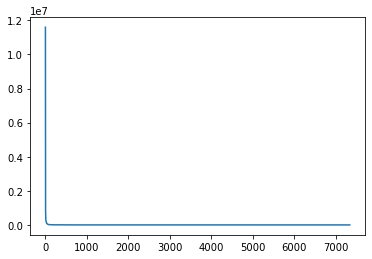

In [ ]:
X.iloc[:,4].value_counts().plot()

<AxesSubplot:>

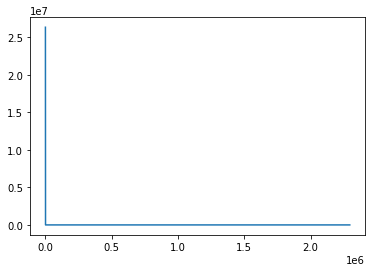

In [ ]:
X.iloc[:,9].value_counts().plot()

<AxesSubplot:>

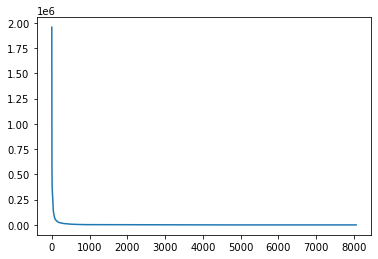

In [ ]:
X.iloc[:,11].value_counts().plot()

<AxesSubplot:>

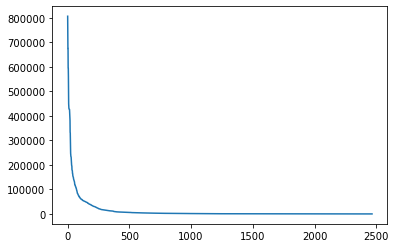

In [ ]:
X.iloc[:,14].value_counts().plot()

<AxesSubplot:>

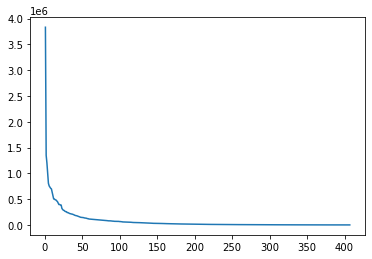

In [ ]:
X.iloc[:,17].value_counts().plot()

In [ ]:
X.groupby("device_id").device_ip.count()

device_id
1          26317545
2             17428
3             11075
4             10505
5              7529
             ...   
2296161           1
2296162           1
2296163           1
2296164           1
2296165           1
Name: device_ip, Length: 2296165, dtype: int64

In [ ]:
X.groupby("device_id").device_ip.mean()

device_id
1          7.212853e+05
2          3.949828e+06
3          7.380981e+05
4          3.359480e+06
5          6.291858e+05
               ...     
2296161    7.531100e+04
2296162    4.890649e+06
2296163    2.022459e+06
2296164    2.395900e+04
2296165    3.362591e+06
Name: device_ip, Length: 2296165, dtype: float64

In [ ]:
X.groupby("device_id").device_ip.var()

device_id
1          1.613332e+12
2          1.213824e+12
3          1.851824e+12
4          1.485912e+11
5          9.207249e+11
               ...     
2296161             NaN
2296162             NaN
2296163             NaN
2296164             NaN
2296165             NaN
Name: device_ip, Length: 2296165, dtype: float64

In [ ]:
X.groupby("device_id").app_id.var()

device_id
1          15611.776985
2              0.000000
3          31158.546698
4              0.000000
5              0.000000
               ...     
2296161             NaN
2296162             NaN
2296163             NaN
2296164             NaN
2296165             NaN
Name: app_id, Length: 2296165, dtype: float64

In [ ]:
X.groupby("device_id").site_id.var()

device_id
1          16903.50717
2              0.00000
3              0.00000
4              0.00000
5              0.00000
              ...     
2296161            NaN
2296162            NaN
2296163            NaN
2296164            NaN
2296165            NaN
Name: site_id, Length: 2296165, dtype: float64

In [ ]:
a = pd.DataFrame(X.groupby("device_id").site_id.var())

In [ ]:
a.loc[a.site_id==0]

,site_id
device_id,
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
...,...
821761,0.0
821762,0.0
821763,0.0


In [ ]:
a.loc[a.site_id>0]

,site_id
device_id,
1,16903.507170
22,58283.666697
52,5172.866006
128,118607.958434
174,101229.351167
...,...
821645,364.500000
821655,302642.000000
821708,158484.500000


In [ ]:
X.groupby("device_id").site_id.mean()

device_id
1           34.177795
2           79.000000
3            1.000000
4          146.000000
5            1.000000
              ...    
2296161      1.000000
2296162      1.000000
2296163      1.000000
2296164      1.000000
2296165      1.000000
Name: site_id, Length: 2296165, dtype: float64

In [ ]:
X.groupby("site_id").device_id.var()

site_id
1       2.066186e+11
2       8.847518e+06
3       0.000000e+00
4       0.000000e+00
5       0.000000e+00
            ...     
4577             NaN
4578             NaN
4579             NaN
4580             NaN
4581             NaN
Name: device_id, Length: 4581, dtype: float64

## 1.2 Data Cleaning

In [ ]:
def get_greater_than(col,threshold_pct):
    threshold = threshold_pct/100 * len(col)
    p = pd.DataFrame(col.value_counts())
    return len(p[p.iloc[:,0]>threshold])

In [ ]:
def clean_data(data, percentage):
    threshold = []
    data1 = data
    for x in range(0, data.shape[1]):
        thres_1 = get_greater_than(data.iloc[:,x], percentage)
        threshold.append(thres_1)
        
    for x in range(0, data.shape[1]):
        data1.iloc[:,x] = np.where(data.iloc[:,x] >= threshold[x], 0, data.iloc[:,x])
    
    return data1

In [ ]:
def get_class_count(col):
    p = pd.DataFrame(col.value_counts())
    return len(p)

In [ ]:
# clean the data with the threshold at 0.01% 
# categories whose occurrence less than 0.01% of datasize will be labelles as 0

X_cleaned = clean_data(X, 0.01)

In [ ]:
Full = pd.concat([X_cleaned, y], axis=1)

# get variane across different categories, the higher the better
class_vars = []
for col in Full.columns:
    class_means = pd.DataFrame(Full.groupby(col)['click'].mean())
    class_vars.append(class_means['click'].var())
    
class_vars = class_vars[0:len(class_vars)-1]

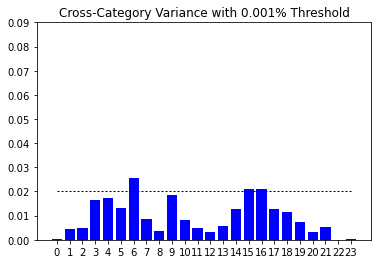

In [ ]:
# 0.001% around 300
plt.bar(np.arange(0, len(class_vars), 1),class_vars,color='blue')
plt.xticks(np.arange(0, len(class_vars), 1))
plt.plot([23, 0, 0], [0.02, 0.02, 0.02], 'k-', lw=1,dashes=[2, 2])
plt.yticks(np.arange(0, 0.1, 0.01))
plt.title("Cross-Category Variance with 0.001% Threshold")
plt.show()

In [ ]:
# print number of unique categories within each column 
for x in range(0, X_cleaned.shape[1]):
    print(str(x),get_class_count(X_cleaned.iloc[:,x]))

0 216
1 7
2 7
3 1173
4 956
5 20
6 900
7 69
8 20
9 137
10 8313
11 2598
12 4
13 4
14 1466
15 8
16 9
17 372
18 4
19 61
20 155
21 55
22 24
23 9


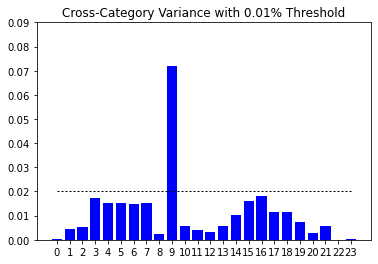

In [ ]:
# 0.01% around 3000
plt.bar(np.arange(0, len(class_vars), 1),class_vars,color='blue')
plt.xticks(np.arange(0, len(class_vars), 1))
plt.plot([23, 0, 0], [0.02, 0.02, 0.02], 'k-', lw=1,dashes=[2, 2])
plt.yticks(np.arange(0, 0.1, 0.01))
plt.title("Cross-Category Variance with 0.01% Threshold")
plt.show()

In [ ]:
for x in range(0, X_cleaned.shape[1]):
    print(str(x),get_class_count(X_cleaned.iloc[:,x]))

0 216
1 7
2 6
3 350
4 267
5 13
6 241
7 30
8 15
9 9
10 272
11 852
12 4
13 4
14 692
15 4
16 5
17 298
18 4
19 56
20 123
21 52
22 24
23 9


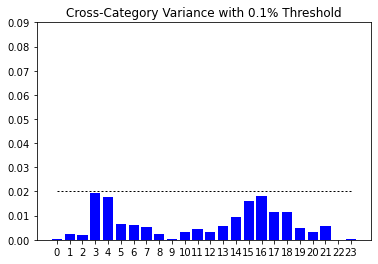

In [ ]:
# 0.1% around 30000
plt.bar(np.arange(0, len(class_vars), 1),class_vars,color='blue')
plt.xticks(np.arange(0, len(class_vars), 1))
plt.plot([23, 0, 0], [0.02, 0.02, 0.02], 'k-', lw=1,dashes=[2, 2])
plt.yticks(np.arange(0, 0.1, 0.01))
plt.title("Cross-Category Variance with 0.1% Threshold")
plt.show()

In [ ]:
for x in range(0, X_cleaned.shape[1]):
    print(str(x),get_class_count(X_cleaned.iloc[:,x]))

0 211
1 4
2 3
3 66
4 62
5 9
6 53
7 18
8 9
9 2
10 22
11 154
12 4
13 4
14 205
15 4
16 5
17 143
18 4
19 43
20 61
21 40
22 24
23 9


In [ ]:
def build_embedded_data_cleaning(train_data):
    
    inputs = {}
    for x in range(0, train_data.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, train_data.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(train_data.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(len(train_data.iloc[:,x].value_counts()))))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(merged_layer)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
build_embedded_data_cleaning = build_embedded_data_cleaning(X_cleaned)

In [ ]:
# 0.1 with initializer, around 30
build_embedded_data_cleaning.fit(X_list, y_train, epochs=3, batch_size=2048, validation_data=(X_test_list, y_test), shuffle=False, verbose=1)

Epoch 1/3
10935/10935 [==============================] - 38s 3ms/step - loss: 0.4083 - val_loss: 0.4058
Epoch 2/3
10935/10935 [==============================] - 36s 3ms/step - loss: 0.4059 - val_loss: 0.4057
Epoch 3/3
10935/10935 [==============================] - 36s 3ms/step - loss: 0.4058 - val_loss: 0.4057


In [ ]:
# 0.01 with initializer, around 3000
build_embedded_data_cleaning.fit(X_list, y_train, epochs=3, batch_size=2048, validation_data=(X_test_list, y_test), shuffle=False, verbose=1)

Epoch 1/3
10935/10935 [==============================] - 44s 4ms/step - loss: 0.4012 - val_loss: 0.3990
Epoch 2/3
10935/10935 [==============================] - 39s 4ms/step - loss: 0.3991 - val_loss: 0.3989
Epoch 3/3
10935/10935 [==============================] - 41s 4ms/step - loss: 0.3990 - val_loss: 0.3988


In [ ]:
# 0.001 with initializer, around 300
build_embedded_data_cleaning.fit(X_list, y_train, epochs=3, batch_size=2048, validation_data=(X_test_list, y_test), shuffle=False, verbose=1)

Epoch 1/3
10935/10935 [==============================] - 102s 9ms/step - loss: 0.3941 - val_loss: 0.3963
Epoch 2/3
10935/10935 [==============================] - 101s 9ms/step - loss: 0.3937 - val_loss: 0.3967
Epoch 3/3
10935/10935 [==============================] - 101s 9ms/step - loss: 0.3933 - val_loss: 0.3971


In [ ]:
### 0.01% threshold gives reasonable number of catergories and has fairly good cross class variance, 
# so we choose 0.01% as the cleaning threshold, which put all categories less than 0.01% * datasize 
# (approimately 3000) as "The Others" (represented by 0 in the ordinal encoding)

## 2. Model Construction

In [ ]:
# full dataset
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.3, random_state=42)

In [ ]:
X_list = []
for i in range(0, X_train.shape[1]):
    X_list.append(X_train.iloc[:,i])
    
X_test_list = []
for i in range(0, X_test.shape[1]):
    X_test_list.append(X_test.iloc[:,i])

In [ ]:
# sample dataset
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

In [ ]:
X_sample_list = []
for i in range(0, X_train_sample.shape[1]):
    X_sample_list.append(X_train_sample.iloc[:,i])
    
X_test_sample_list = []
for i in range(0, X_test_sample.shape[1]):
    X_test_sample_list.append(X_test_sample.iloc[:,i])    

### 2.1 Baseline Model

In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 42, 
                            min_samples_split=300, max_depth=30, n_jobs=4)

rf.fit(X_train_sample, y_train_sample)

In [ ]:
from sklearn.metrics import log_loss
prediction = rf.predict_proba(X_test_sample)
log_loss(y_test_sample,prediction)

# 0.39528884102584344

In [ ]:
# Logistics Regression

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42,n_jobs=4,penalty="l2").fit(X_train_sample, y_train_sample)

In [ ]:
from sklearn.metrics import log_loss
prediction_lr = clf.predict_proba(X_test_sample)
log_loss(y_test_sample,prediction_lr)

# 0.4497992453708017

## 2.2 Embedded Neural Network

### 2.2.1 Test Embedding Ouput

In [ ]:
# frist, have tried using half or full of the number of categories as output dim, but they tend to overfit 
# try some other rule of thumbs
# https://mmuratarat.github.io/2019-06-12/embeddings-with-numeric-variables-Keras

In [ ]:
def build_embedded_model_sqrt(train_data):
    
    inputs = {}
    for x in range(0, train_data.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, train_data.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(train_data.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(len(train_data.iloc[:,x].value_counts()))))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(merged_layer)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
def build_embedded_model_fourth_sqrt(train_data):
    
    inputs = {}
    for x in range(0, train_data.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, train_data.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(train_data.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(math.sqrt(len(train_data.iloc[:,x].value_counts())))))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(merged_layer)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
def build_embedded_model_half_50(train_data):
    
    inputs = {}
    for x in range(0, train_data.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, train_data.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(train_data.iloc[:,x])+1,
                                                                     output_dim=min(50, math.ceil(len(train_data.iloc[:,x].value_counts())/2)))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(merged_layer)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
embedded_model_sqrt = build_embedded_model_sqrt(X_train_sample)

In [ ]:
embedded_model_fourth_sqrt = build_embedded_model_fourth_sqrt(X_train_sample)

In [ ]:
embedded_model_half_50 = build_embedded_model_half_50(X_train_sample)

In [ ]:
# sqrt
embedded_model_sqrt.fit(X_sample_list, y_train_sample, epochs=2, batch_size=4096, validation_data=(X_test_sample_list, y_test_sample), shuffle=False, verbose=1)

Epoch 1/2
1094/1094 [==============================] - 38s 34ms/step - loss: 0.4109 - val_loss: 0.3968
Epoch 2/2
1094/1094 [==============================] - 34s 31ms/step - loss: 0.3959 - val_loss: 0.3964


In [ ]:
# fourth_sqrt
embedded_model_fourth_sqrt.fit(X_sample_list, y_train_sample, epochs=2, batch_size=4096, validation_data=(X_test_sample_list, y_test_sample), shuffle=False, verbose=1)

Epoch 1/2
1094/1094 [==============================] - 19s 16ms/step - loss: 0.4231 - val_loss: 0.3983
Epoch 2/2
1094/1094 [==============================] - 14s 13ms/step - loss: 0.3966 - val_loss: 0.3966


In [ ]:
# half_50
embedded_model_half_50.fit(X_sample_list, y_train_sample, epochs=2, batch_size=4096, validation_data=(X_test_sample_list, y_test_sample), shuffle=False, verbose=1)

Epoch 1/2
1094/1094 [==============================] - 58s 50ms/step - loss: 0.4081 - val_loss: 0.39673s - loss: 0. - ETA: 3s - loss: 0. -  - ETA: 1s - loss: 0.409 - ETA: 1s - - ETA: 0s - loss: 0 - ETA: 0s - loss: 0. - ETA: 0s - loss: 0
Epoch 2/2
1094/1094 [==============================] - 54s 49ms/step - loss: 0.3959 - val_loss: 0.39658s - loss: 0. - ETA: 8s -  - ETA: 7s - loss: 0.395 - ETA: 7s - loss: - ETA: 7s - loss: 0.39 - ETA: 7s - loss: 0.395 - ETA: 7s - loss:  - ETA: 6s - lo - ETA - ETA: 0s - lo


In [ ]:
### clearly, too large output dimension overfit the data, sqrt is the best currently

In [ ]:
### Genrally, sqrt is quick and perform well, so we use sqrt as output dim

### 2.2.2 Hyperparameter Tuning

In [ ]:
# first try some different set of params to get a general idea

In [ ]:
def build_tuning_model(hp):
    
    inputs = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(X_cleaned.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(max(X_cleaned.iloc[:,x]))))\
                                                          (inputs["input_{0}".format(x)])
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    x = concatenate(list(inputs_embedded.values()))
    
    for i in range(hp.Int('layers',2,4)):
        x = Dense(units = hp.Choice('units_'+str(i),[32,64,128,256]), activation='relu',
                  kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
        
    # use Relu because:
    # https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('learning_rate', [1e-2,1e-3,1e-4])))
   
    return model

In [ ]:
# first tune

In [ ]:
bayesian_opt_tuner = BayesianOptimization(
    build_tuning_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
overwrite = True)

In [ ]:
bayesian_opt_tuner.search(X_sample_list, y_train_sample, epochs=5, batch_size=4096 ,
                          validation_data=(X_test_sample_list, y_test_sample), 
             shuffle=True, verbose=1)

Trial 10 Complete [00h 06m 39s]
val_loss: 0.3941546678543091

Best val_loss So Far: 0.39375409483909607
Total elapsed time: 01h 06m 10s
INFO:tensorflow:Oracle triggered exit


In [ ]:
bayesian_opt_tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layers: 2
units_0: 32
units_1: 256
learning_rate: 0.01
Score: 0.39375409483909607
Trial summary
Hyperparameters:
layers: 4
units_0: 32
units_1: 256
learning_rate: 0.01
units_2: 256
units_3: 32
Score: 0.39397719502449036
Trial summary
Hyperparameters:
layers: 4
units_0: 32
units_1: 32
learning_rate: 0.01
units_2: 256
units_3: 32
Score: 0.3941492736339569
Trial summary
Hyperparameters:
layers: 3
units_0: 32
units_1: 256
learning_rate: 0.01
units_2: 32
units_3: 32
Score: 0.3941546678543091
Trial summary
Hyperparameters:
layers: 4
units_0: 32
units_1: 32
learning_rate: 0.01
units_2: 32
units_3: 32
Score: 0.3941642642021179
Trial summary
Hyperparameters:
layers: 2
units_0: 32
units_1: 32
learning_rate: 0.01
units_2: 32
units_3: 32
Score: 0.39423510432243347
Trial summary
Hyperparameters:
layers: 2
units_0: 32
units_1: 256
learning_rate: 0.01
units_2

In [ ]:
# 2nd tune

In [ ]:
def build_tuning_model_2(hp):
    
    inputs = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(X_cleaned.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(max(X_cleaned.iloc[:,x]))))\
                                                          (inputs["input_{0}".format(x)])
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    x = concatenate(list(inputs_embedded.values()))
    
    for i in range(hp.Int('layers',1,4)):
        x = Dense(units = hp.Choice('units_'+str(i),[32,64,128,256]), 
                  activation=hp.Choice('activation_'+str(i),['relu','sigmoid','tanh']),
                  kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('learning_rate', [1e-2,1e-3,1e-4])))
   
    return model

In [ ]:
bayesian_opt_tuner2 = BayesianOptimization(
    build_tuning_model_2,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
overwrite = True)

In [ ]:
bayesian_opt_tuner2.search(X_sample_list, y_train_sample, epochs=4, batch_size=4096 ,
                          validation_data=(X_test_sample_list, y_test_sample), 
             shuffle=True, verbose=1)

Trial 15 Complete [00h 03m 12s]
val_loss: 0.3945039212703705

Best val_loss So Far: 0.3937508165836334
Total elapsed time: 00h 46m 39s
INFO:tensorflow:Oracle triggered exit


In [ ]:
bayesian_opt_tuner2.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layers: 3
units_0: 256
activation_0: relu
learning_rate: 0.01
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
units_3: 64
activation_3: relu
Score: 0.3937508165836334
Trial summary
Hyperparameters:
layers: 4
units_0: 256
activation_0: relu
learning_rate: 0.01
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
units_3: 32
activation_3: tanh
Score: 0.3939097821712494
Trial summary
Hyperparameters:
layers: 3
units_0: 32
activation_0: relu
learning_rate: 0.01
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
Score: 0.3940255343914032
Trial summary
Hyperparameters:
layers: 1
units_0: 256
activation_0: sigmoid
learning_rate: 0.01
Score: 0.3944421410560608
Trial summary
Hyperparameters:
layers: 4
units_0: 128
activation_0: tanh
learning_rate: 0.01
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
units_

In [ ]:
# 3rd tune

In [ ]:
def build_tuning_model_3(hp):
    
    inputs = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(X_cleaned.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(max(X_cleaned.iloc[:,x]))))\
                                                          (inputs["input_{0}".format(x)])
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    x = concatenate(list(inputs_embedded.values()))
    
    x = Dense(units = hp.Choice('units_1',[32,64,128,256]), 
                  activation=hp.Choice('activation_1',['relu','sigmoid','tanh']),
                  kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    x = Dense(units = hp.Choice('units_2',[32,64,128,256]), 
                  activation=hp.Choice('activation_2',['relu','sigmoid','tanh']),
                  kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('learning_rate', [1e-3])))
   
    return model

In [ ]:
bayesian_opt_tuner3 = BayesianOptimization(
    build_tuning_model_3,
    objective='val_loss',
    max_trials=6,
    executions_per_trial=1,
overwrite = True)

In [ ]:
bayesian_opt_tuner3.search(X_sample_list, y_train_sample, epochs=6, batch_size=512 ,
                          validation_data=(X_test_sample_list, y_test_sample), 
             shuffle=True, verbose=1)

Trial 5 Complete [00h 12m 52s]
val_loss: 0.3929181396961212

Best val_loss So Far: 0.3929181396961212
Total elapsed time: 00h 49m 53s

Search: Running Trial #6

Hyperparameter    |Value             |Best Value So Far 
units_1           |256               |256               
activation_1      |relu              |relu              
units_2           |128               |256               
activation_2      |relu              |relu              
learning_rate     |0.001             |0.001             

Epoch 1/6
8748/8748 [==============================] - 104s 12ms/step - loss: 0.4002 - val_loss: 0.3964
Epoch 2/6
8748/8748 [==============================] - 101s 12ms/step - loss: 0.3951 - val_loss: 0.3943
Epoch 3/6
7056/8748 [=======================>......] - ETA: 7s - loss: 0.3930

In [ ]:
# not very clear after this tuning, so next try different layers one by one

## 1-Layer NN

In [ ]:
def build_embedded_model_1_layer(train_data):
    
    inputs = {}
    for x in range(0, train_data.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, train_data.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(train_data.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(len(train_data.iloc[:,x].value_counts()))))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    x = Dense(units = 512, activation='relu',
              kernel_initializer=initializers.RandomNormal(stddev=0.01),
              kernel_regularizer=regularizers.l2(0.001))(merged_layer)
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
build_embedded_model_1_layer = build_embedded_model_1_layer(X_train)

In [ ]:
# regularizer, 512 batch, 512 neuron
build_embedded_model_1_layer.fit(X_sample_list, y_train_sample, epochs=3, batch_size=512, validation_data=(X_test_sample_list, y_test_sample), 
                                 shuffle=False, verbose=1)

Epoch 1/3
8748/8748 [==============================] - 144s 16ms/step - loss: 0.4054 - val_loss: 0.4025
Epoch 2/3
8748/8748 [==============================] - 132s 15ms/step - loss: 0.4010 - val_loss: 0.4011
Epoch 3/3
8748/8748 [==============================] - 134s 15ms/step - loss: 0.3999 - val_loss: 0.4007


In [ ]:
# regularizer, 2048 batch, 512 neuron
build_embedded_model_1_layer.fit(X_sample_list, y_train_sample, epochs=3, batch_size=2048, validation_data=(X_test_sample_list, y_test_sample), 
                                 shuffle=False, verbose=1)

Epoch 1/3
2187/2187 [==============================] - 81s 37ms/step - loss: 0.3988 - val_loss: 0.4000
Epoch 2/3
2187/2187 [==============================] - 74s 34ms/step - loss: 0.3985 - val_loss: 0.3999
Epoch 3/3
2187/2187 [==============================] - 79s 36ms/step - loss: 0.3981 - val_loss: 0.3997


In [ ]:
# regularizer, 256 batch, 512 neuron
build_embedded_model_1_layer.fit(X_sample_list, y_train_sample, epochs=3, batch_size=256, validation_data=(X_test_sample_list, y_test_sample), 
                                 shuffle=False, verbose=1)

Epoch 1/3
17496/17496 [==============================] - 210s 12ms/step - loss: 0.3989 - val_loss: 0.4002
Epoch 2/3
17496/17496 [==============================] - 200s 11ms/step - loss: 0.3979 - val_loss: 0.4001
Epoch 3/3
17496/17496 [==============================] - 202s 12ms/step - loss: 0.3973 - val_loss: 0.4001


In [ ]:
# regularizer, 4096 batch, 512 neuron
build_embedded_model_1_layer.fit(X_list, y_train, epochs=3, batch_size=4096, validation_data=(X_test_list, y_test), 
                                 shuffle=False, verbose=1)

Epoch 1/3
5468/5468 [==============================] - 169s 31ms/step - loss: 0.3970 - val_loss: 0.3967
Epoch 2/3
5468/5468 [==============================] - 165s 30ms/step - loss: 0.3965 - val_loss: 0.3963
Epoch 3/3
5468/5468 [==============================] - 167s 31ms/step - loss: 0.3961 - val_loss: 0.3961


## 2-Layer NN

In [ ]:
def build_embedded_model_2_layer(hp):
    
    inputs = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(X_cleaned.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(len(X_cleaned.iloc[:,x].value_counts()))))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    x = Dense(units = 512, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(merged_layer)
    
    #kernel_regularizer=regularizers.l2(0.001)
    
    x = Dense(units = 512, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
build_embedded_model_2_layer = build_embedded_model_2_layer('')

In [ ]:
# 512+512
build_embedded_model_2_layer.fit(X_list, y_train, epochs=7, batch_size=512, validation_data=(X_test_list, y_test), 
                                 shuffle=False, verbose=1)

Epoch 1/7
43738/43738 [==============================] - 354s 8ms/step - loss: 0.3947 - val_loss: 0.3918
Epoch 2/7
43738/43738 [==============================] - 349s 8ms/step - loss: 0.3911 - val_loss: 0.3906
Epoch 3/7
43738/43738 [==============================] - 349s 8ms/step - loss: 0.3899 - val_loss: 0.3901
Epoch 4/7
43738/43738 [==============================] - 349s 8ms/step - loss: 0.3891 - val_loss: 0.3899
Epoch 5/7
43738/43738 [==============================] - 349s 8ms/step - loss: 0.3885 - val_loss: 0.3897
Epoch 6/7
43738/43738 [==============================] - 351s 8ms/step - loss: 0.3880 - val_loss: 0.3897
Epoch 7/7
43738/43738 [==============================] - 350s 8ms/step - loss: 0.3876 - val_loss: 0.3897


In [ ]:
# 512+512
build_embedded_model_2_layer.fit(X_list, y_train, epochs=5, batch_size=4096, validation_data=(X_test_list, y_test), 
                                 shuffle=False, verbose=1)

Epoch 1/5
5468/5468 [==============================] - 189s 35ms/step - loss: 0.3848 - val_loss: 0.3898
Epoch 2/5
5468/5468 [==============================] - 191s 35ms/step - loss: 0.3846 - val_loss: 0.3898
Epoch 3/5
5468/5468 [==============================] - 191s 35ms/step - loss: 0.3844 - val_loss: 0.3900
Epoch 4/5
5468/5468 [==============================] - 191s 35ms/step - loss: 0.3843 - val_loss: 0.3901
Epoch 5/5
5468/5468 [==============================] - 191s 35ms/step - loss: 0.3841 - val_loss: 0.3903


In [ ]:
# 1024+512 no regularizer ON SAMPLE
build_embedded_model_2_layer.fit(X_sample_list, y_train_sample, epochs=8, batch_size=4096, validation_data=(X_test_sample_list, y_test_sample), 
                                 shuffle=False, verbose=1)

Epoch 1/8
1094/1094 [==============================] - 126s 114ms/step - loss: 0.4034 - val_loss: 0.3966
Epoch 2/8
1094/1094 [==============================] - 130s 119ms/step - loss: 0.3955 - val_loss: 0.3949
Epoch 3/8
1094/1094 [==============================] - 128s 117ms/step - loss: 0.3934 - val_loss: 0.3939
Epoch 4/8
1094/1094 [==============================] - 129s 118ms/step - loss: 0.3920 - val_loss: 0.3937
Epoch 5/8
1094/1094 [==============================] - 129s 118ms/step - loss: 0.3908 - val_loss: 0.3934
Epoch 6/8
1094/1094 [==============================] - 129s 118ms/step - loss: 0.3897 - val_loss: 0.3934
Epoch 7/8
1094/1094 [==============================] - 129s 118ms/step - loss: 0.3887 - val_loss: 0.3937
Epoch 8/8
 403/1094 [==========>...................] - ETA: 34s - loss: 0.3877

KeyboardInterrupt: 

## 3 Layer NN

In [ ]:
def build_embedded_model_3_layer(hp):
    
    inputs = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(X_cleaned.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(len(X_cleaned.iloc[:,x].value_counts()))))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    x = Dense(units = 512, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(merged_layer)
    x = Dense(units = 32, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    #kernel_regularizer=regularizers.l2(0.001)
    x = Dense(units = 32, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
build_embedded_model_3_layer = build_embedded_model_3_layer('')

In [ ]:
# 256+32+32 no regularizer ON FULL
build_embedded_model_3_layer.fit(X_list, y_train, epochs=7, batch_size=4096, validation_data=(X_test_list, y_test), 
                                 shuffle=False, verbose=1)

Epoch 1/7
5468/5468 [==============================] - 64s 11ms/step - loss: 0.3982 - val_loss: 0.3932
Epoch 2/7
5468/5468 [==============================] - 59s 11ms/step - loss: 0.3923 - val_loss: 0.3917
Epoch 3/7
5468/5468 [==============================] - 60s 11ms/step - loss: 0.3910 - val_loss: 0.3912
Epoch 4/7
5468/5468 [==============================] - 60s 11ms/step - loss: 0.3901 - val_loss: 0.3907
Epoch 5/7
5468/5468 [==============================] - 61s 11ms/step - loss: 0.3895 - val_loss: 0.3904
Epoch 6/7
5468/5468 [==============================] - 60s 11ms/step - loss: 0.3889 - val_loss: 0.3901
Epoch 7/7
5468/5468 [==============================] - 60s 11ms/step - loss: 0.3884 - val_loss: 0.3899


In [ ]:
# 256+32+32 regularizer ON FULL
build_embedded_model_3_layer.fit(X_list, y_train, epochs=9, batch_size=4096, validation_data=(X_test_list, y_test), 
                                 shuffle=False, verbose=1)

Epoch 1/9
5468/5468 [==============================] - 67s 12ms/step - loss: 0.4092 - val_loss: 0.4045
Epoch 2/9
5468/5468 [==============================] - 61s 11ms/step - loss: 0.4039 - val_loss: 0.4036
Epoch 3/9
5468/5468 [==============================] - 61s 11ms/step - loss: 0.4032 - val_loss: 0.4029
Epoch 4/9
5468/5468 [==============================] - 61s 11ms/step - loss: 0.4028 - val_loss: 0.4025
Epoch 5/9
5468/5468 [==============================] - 61s 11ms/step - loss: 0.4025 - val_loss: 0.4023
Epoch 6/9
5468/5468 [==============================] - 61s 11ms/step - loss: 0.4022 - val_loss: 0.4021
Epoch 7/9
5468/5468 [==============================] - 62s 11ms/step - loss: 0.4021 - val_loss: 0.4020
Epoch 8/9
5468/5468 [==============================] - 62s 11ms/step - loss: 0.4019 - val_loss: 0.4019
Epoch 9/9
5468/5468 [==============================] - 61s 11ms/step - loss: 0.4018 - val_loss: 0.4019


In [ ]:
# 128+128+128 regularizer ON FULL
build_embedded_model_3_layer.fit(X_list, y_train, epochs=9, batch_size=4096, validation_data=(X_test_list, y_test), 
                                 shuffle=False, verbose=1)

Epoch 1/9
5468/5468 [==============================] - 66s 12ms/step - loss: 0.3977 - val_loss: 0.3931
Epoch 2/9
5468/5468 [==============================] - 64s 12ms/step - loss: 0.3924 - val_loss: 0.3917
Epoch 3/9
5468/5468 [==============================] - 64s 12ms/step - loss: 0.3912 - val_loss: 0.3911
Epoch 4/9
5468/5468 [==============================] - 64s 12ms/step - loss: 0.3903 - val_loss: 0.3909
Epoch 5/9
5468/5468 [==============================] - 65s 12ms/step - loss: 0.3897 - val_loss: 0.3906
Epoch 6/9
5468/5468 [==============================] - 64s 12ms/step - loss: 0.3892 - val_loss: 0.3903
Epoch 7/9
5468/5468 [==============================] - 64s 12ms/step - loss: 0.3887 - val_loss: 0.3902
Epoch 8/9
5468/5468 [==============================] - 64s 12ms/step - loss: 0.3884 - val_loss: 0.3900
Epoch 9/9
5468/5468 [==============================] - 64s 12ms/step - loss: 0.3880 - val_loss: 0.3899


In [ ]:
# 128+32+32 no regularizer ON SAMPLE
build_embedded_model_3_layer.fit(X_sample_list, y_train_sample, epochs=9, batch_size=2048, validation_data=(X_test_sample_list, y_test_sample), 
                                 shuffle=False, verbose=1)

Epoch 1/9
2187/2187 [==============================] - 32s 14ms/step - loss: 0.4068 - val_loss: 0.3981
Epoch 2/9
2187/2187 [==============================] - 27s 12ms/step - loss: 0.3966 - val_loss: 0.3962
Epoch 3/9
2187/2187 [==============================] - 28s 13ms/step - loss: 0.3948 - val_loss: 0.3953
Epoch 4/9
2187/2187 [==============================] - 29s 13ms/step - loss: 0.3935 - val_loss: 0.3947
Epoch 5/9
2187/2187 [==============================] - 27s 13ms/step - loss: 0.3926 - val_loss: 0.3944
Epoch 6/9
2187/2187 [==============================] - 29s 13ms/step - loss: 0.3918 - val_loss: 0.3942
Epoch 7/9
2187/2187 [==============================] - 28s 13ms/step - loss: 0.3912 - val_loss: 0.3941
Epoch 8/9
2187/2187 [==============================] - 28s 13ms/step - loss: 0.3907 - val_loss: 0.3939
Epoch 9/9
2187/2187 [==============================] - 29s 13ms/step - loss: 0.3901 - val_loss: 0.3939


In [ ]:
# 512+32+32 no regularizer ON SAMPLE
build_embedded_model_3_layer.fit(X_sample_list, y_train_sample, epochs=10, batch_size=2048, validation_data=(X_test_sample_list, y_test_sample), 
                                 shuffle=False, verbose=1)

Epoch 1/10
2187/2187 [==============================] - 48s 21ms/step - loss: 0.4055 - val_loss: 0.3976
Epoch 2/10
2187/2187 [==============================] - 46s 21ms/step - loss: 0.3960 - val_loss: 0.3957
Epoch 3/10
2187/2187 [==============================] - 47s 21ms/step - loss: 0.3941 - val_loss: 0.3948
Epoch 4/10
2187/2187 [==============================] - 47s 21ms/step - loss: 0.3928 - val_loss: 0.3942
Epoch 5/10
2187/2187 [==============================] - 47s 21ms/step - loss: 0.3917 - val_loss: 0.3938
Epoch 6/10
2187/2187 [==============================] - 47s 21ms/step - loss: 0.3908 - val_loss: 0.3936
Epoch 7/10
2187/2187 [==============================] - 47s 21ms/step - loss: 0.3900 - val_loss: 0.3936
Epoch 8/10
2187/2187 [==============================] - 47s 21ms/step - loss: 0.3892 - val_loss: 0.3936
Epoch 9/10
2187/2187 [==============================] - 47s 21ms/step - loss: 0.3884 - val_loss: 0.3937
Epoch 10/10
2187/2187 [==============================] - 47s 21m

## 4 Layer

In [ ]:
def build_embedded_model_4_layer(hp):
    
    inputs = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs["input_{0}".format(x)] = Input(shape=(1,))
        
    inputs_embedded = {}
    for x in range(0, X_cleaned.shape[1]):
        inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(X_cleaned.iloc[:,x])+1,
                                                                     output_dim=math.ceil(math.sqrt(len(X_cleaned.iloc[:,x].value_counts()))))\
                                                          (inputs["input_{0}".format(x)])
                                                                     
        inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])
    
    merged_layer = concatenate(list(inputs_embedded.values()))
    
    x = Dense(units = 64, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(merged_layer)
    x = Dense(units = 32, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    #kernel_regularizer=regularizers.l2(0.001)
    x = Dense(units = 32, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    x = Dense(units = 32, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    output = Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
    
    model = Model(inputs=list(inputs.values()), outputs=[output])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-2))
   
    return model

In [ ]:
build_embedded_model_4_layer = build_embedded_model_4_layer('')

In [ ]:
# 64+32+32+32 ON FULL
build_embedded_model_4_layer.fit(X_list, y_train, epochs=9, batch_size=4096, validation_data=(X_test_list, y_test), 
                                 shuffle=False, verbose=1)

Epoch 1/9
5468/5468 [==============================] - 50s 8ms/step - loss: 0.3969 - val_loss: 0.3936
Epoch 2/9
5468/5468 [==============================] - 46s 8ms/step - loss: 0.3928 - val_loss: 0.3923
Epoch 3/9
5468/5468 [==============================] - 46s 8ms/step - loss: 0.3917 - val_loss: 0.3917
Epoch 4/9
5468/5468 [==============================] - 45s 8ms/step - loss: 0.3911 - val_loss: 0.3917
Epoch 5/9
5468/5468 [==============================] - 46s 8ms/step - loss: 0.3906 - val_loss: 0.3912
Epoch 6/9
5468/5468 [==============================] - 45s 8ms/step - loss: 0.3903 - val_loss: 0.3913
Epoch 7/9
5468/5468 [==============================] - 46s 8ms/step - loss: 0.3901 - val_loss: 0.3914
Epoch 8/9
5468/5468 [==============================] - 46s 8ms/step - loss: 0.3898 - val_loss: 0.3912
Epoch 9/9
5468/5468 [==============================] - 45s 8ms/step - loss: 0.3896 - val_loss: 0.3912


In [ ]:
# wide layer perform the best.
# too many layer is time consuming and is prune to overfit
# use 2 layer 512+512 as the final model

In [ ]:
# we in fact conducted more test, however, these test data are on each teammate's computer
# so just include part of them here

## 3. Prediction

In [ ]:
# categorical inputs
inputs = {}
for x in range(0, X_cleaned.shape[1]-3):
    inputs["input_{0}".format(x)] = Input(shape=(1,))

inputs_embedded = {}
for x in range(0, X_cleaned.shape[1]-3):
    inputs_embedded["inputs_embedded_{0}".format(x)] = Embedding(input_dim=max(X_cleaned.iloc[:,x])+1,
                                                                 output_dim=math.ceil(math.sqrt(len(X_cleaned.iloc[:,x].value_counts()))))\
                                                      (inputs["input_{0}".format(x)])

    inputs_embedded["inputs_embedded_{0}".format(x)] = Flatten()(inputs_embedded["inputs_embedded_{0}".format(x)])

# numerical inputs
numeric_inputs = Input(shape=(3,))

input_list = list(inputs_embedded.values())
input_list.append(numeric_inputs)

merged_layer = concatenate(input_list)

In [ ]:
def build_embedded_model_2_layer(hp):

    x = Dense(units = 512, activation='relu',)(merged_layer)
    x = Dense(units = 512, activation='relu')(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    input_list_2 = list(inputs.values())
    input_list_2.append(numeric_inputs)
    
    model = Model(inputs=input_list_2, outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))
   
    return model

In [ ]:
embedded_model_2_layer = build_embedded_model_2_layer('')

In [ ]:
embedded_model_2_layer.fit(X_train_list, y_train, epochs=15, batch_size=2048, validation_split=0.3, 
                                 shuffle=True, verbose=1,callbacks=EarlyStopping(monitor='val_loss',patience=1))

In [ ]:
# get test data and process as we did for the training data

In [ ]:
data = pd.read_csv(r'C:/Users/zhua273/Desktop/Project Data/ProjectTestData.csv')

In [ ]:
data = data.drop(['id'],axis=1)
data['hh'] = data['hour'].mod(100)
data['dd'] = (data['hour']-data['hh']-14100000)/100
weekday_mapping = {21: 1, 22: 2, 23: 3, 24: 4, 25:5, 26:6, 27:7, 28:1, 29:2, 30:3, 31:4}
data['weekday'] = data['dd'].map(weekday_mapping)
data = data.drop(['hour'],axis=1)

In [ ]:
for x in range(0, data.shape[1]-3): # keep hour, day and weekday as numerical variables
    data.iloc[:,x] = data.iloc[:,x].map(mappings["mappings_{0}".format(x)]).fillna(0)

In [ ]:
data = clean_data(data, 0.01)

In [ ]:
test_list = get_X_list(data)

In [ ]:
for x in range(0,data.shape[1]-3):
    data.iloc[:,x] = np.where(data.iloc[:,x] >= max(X_cleaned.iloc[:,x]), 0, data.iloc[:,x])

In [ ]:
pred = embedded_model_2_layer.predict(test_list)

In [ ]:
data['Prediction'] = pred

In [ ]:
data.to_csv("C:/Users/zhua273/Desktop/Project Data/pred.csv",index=False)